In [1]:
import pyrootutils
import os

# Set the project root using the current working directory
project_root = pyrootutils.setup_root(os.getcwd(), indicator=".git", pythonpath=True, cwd=True)
print("Working directory set to:", os.getcwd())

Working directory set to: /home/ec2-user/embedding-adapter


In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import os
import torch
import pandas as pd
import numpy as np

from embedding_adapter.triplet_module import TripletModule

/home/ec2-user/embedding-adapter/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Load the trained model from checkpoint
checkpoint_path = f"logs/products/triplet_model_2025-05-12_05-57-01_33bfda/checkpoints/triplet-model-best-ood-val.ckpt"

model = TripletModule.load_from_checkpoint(checkpoint_path, map_location=torch.device('cuda'), dtype=dtype)
model.eval()

TripletModule(
  (adapter): LinearMoEAdapter(
    (shared_adapter): Sequential(
      (0): RMSNorm((4096,), eps=None, elementwise_affine=False)
      (1): Linear(in_features=4096, out_features=1024, bias=True)
      (2): GELU(approximate='none')
    )
    (experts): ModuleList(
      (0-127): 128 x Sequential(
        (0): Linear(in_features=1024, out_features=32, bias=False)
        (1): Linear(in_features=32, out_features=1024, bias=False)
      )
    )
    (gate_network): Sequential(
      (0): Linear(in_features=4096, out_features=4096, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=4096, out_features=128, bias=True)
    )
    (noise_layer): Linear(in_features=4096, out_features=128, bias=True)
  )
  (loss_fn): TripletLoss(
    (criterion): CrossEntropyLoss()
  )
  (in_batch_loss_fn): JointInfoNCELoss()
)

In [6]:
def cosine_similarity_matrix(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
    norm_tensor1 = tensor1 / tensor1.norm(dim=1, keepdim=True)
    norm_tensor2 = tensor2 / tensor2.norm(dim=1, keepdim=True)
    return torch.mm(norm_tensor1, norm_tensor2.t())

In [7]:
train_tasks = pd.read_parquet("data/products/sfr/train_tasks.parquet")
train_tasks['split'] = 'train'

ood_tasks = pd.read_parquet("data/products/sfr/ood_tasks.parquet")
ood_tasks['split'] = 'ood'

In [8]:
tasks = pd.concat([train_tasks, ood_tasks])

In [9]:
task_embeddings = torch.tensor(np.stack(tasks['embedding_task'])).to(dtype)

In [10]:
task_embeddings = torch.nn.functional.normalize(task_embeddings, dim=1, p=2)

In [11]:
cosine_sim = cosine_similarity_matrix(task_embeddings, task_embeddings)

In [12]:
tasks['cosine_sim'] = cosine_sim[2]

In [13]:
STEP_SIZE = 50
tasks_sorted = tasks[['id_task', 'task', 'cosine_sim', 'split', 'embedding_task']].sort_values(by='cosine_sim', ascending=False).iloc[:30*STEP_SIZE:STEP_SIZE]

In [14]:
tasks_sorted

,id_task,task,cosine_sim,split,embedding_task
9147,72f3b049-99e5-4907-b92c-dda5c94a0fac,Analyze the opacity level of yoga pants fabric...,1.000000,train,"[0.003561, -0.000432, 0.00268, -0.002241, -0.0..."
10210,614e25f6-a09f-495c-9a8c-a0000c01dff0,Analyze the level of opacity in curtain fabric...,0.798974,train,"[0.001634, 0.011986, 0.00484, 0.011055, -0.035..."
4956,3b3d062a-886c-4b0c-b08c-584e12d7e973,Identify the material composition of the yoga ...,0.769685,train,"[0.016, -0.001517, -0.01106, -0.006786, -0.001..."
14299,833e73e7-85f9-4d72-9ce2-75518b9df17f,The material composition of this yoga mat shou...,0.752146,train,"[0.005898, 0.0009313, -0.004597, -0.00904, -0...."
8360,d2436c2c-1bd0-4c68-bb59-62992320ee7a,Can you determine the specific shade intensity...,0.743633,train,"[-0.00765, 0.01701, -0.006794, 0.00427, -0.017..."
24413,7b377bc2-89a3-4932-9d5e-efc589cb744e,Identify the weight specification (in pounds) ...,0.738014,train,"[-0.0016, 0.003235, -0.01328, -0.00875, -0.009..."
7960,cb6b669e-d1e8-4720-b00f-7053a79495af,Locate and identify the fabric type used in th...,0.732899,train,"[-0.0001857, 0.01305, 0.00089, 0.00203, -0.017..."
19330,e9492ca6-c15a-4a34-aaeb-a21cfa1f39a9,Extract the textile information from this swim...,0.729575,ood,"[0.00582, 0.001368, -0.003222, 0.0061, -0.0099..."
22052,1f8e1376-20ed-4312-bd11-9f66469b1c55,"From the dress specifications, determine the m...",0.727087,train,"[0.00832, 0.003054, 0.006325, -0.0159, -0.0188..."
3354,2aa2404d-790a-4165-9afa-b26934be4e4a,Find the specific tone of grey featured in thi...,0.723507,train,"[-0.004025, 0.007545, -0.004715, -0.01505, -0...."


In [15]:
with torch.inference_mode():
    top_embeddings = torch.tensor(np.stack(tasks_sorted['embedding_task'])).to(device=device, dtype=dtype)
    gates, prob_of_topk = model.adapter.noisy_top_k_gating(top_embeddings, use_noise=True)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

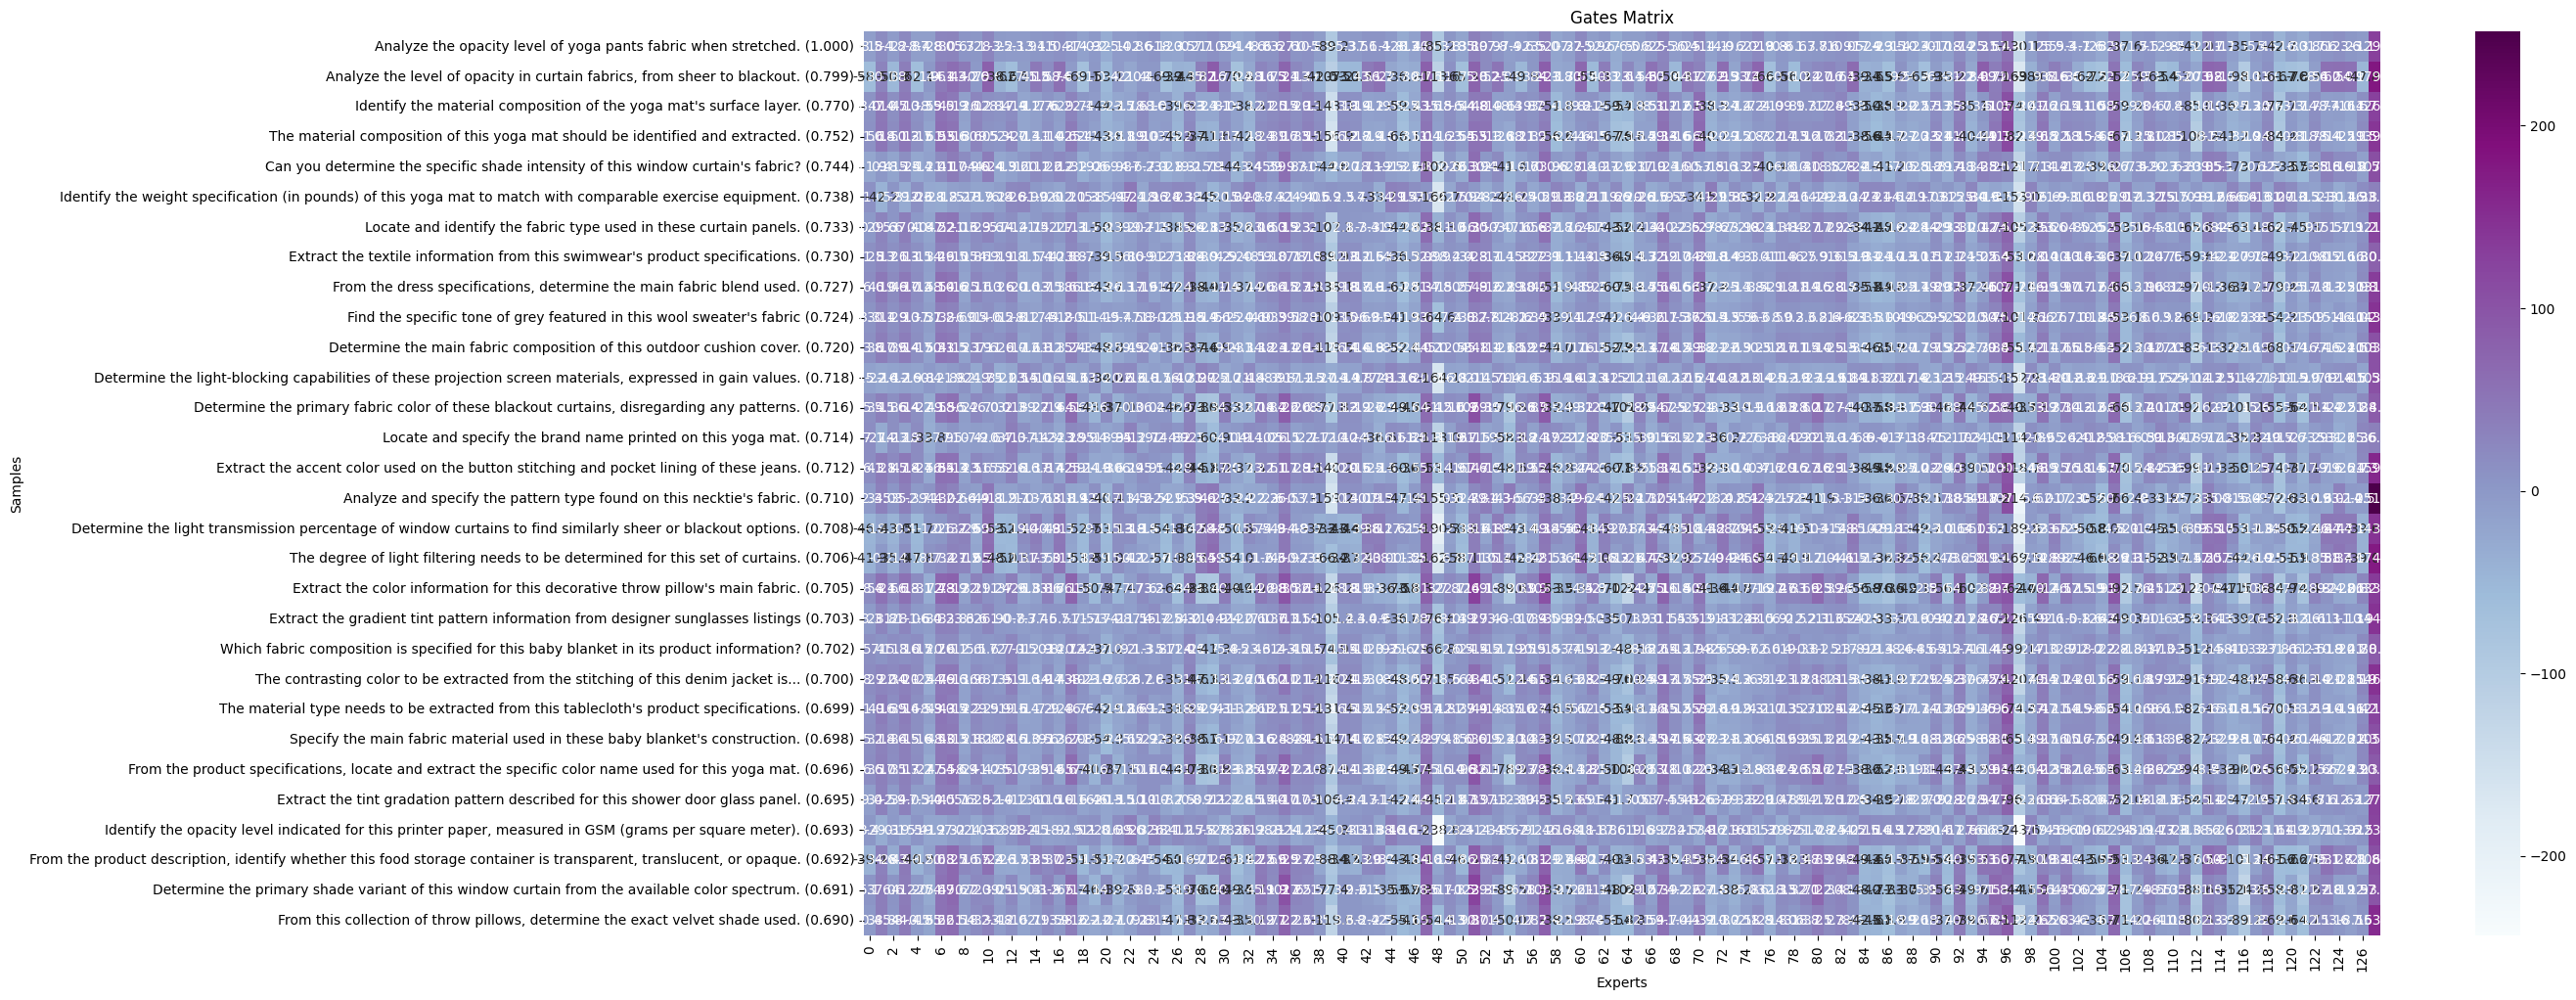

In [18]:
plt.figure(figsize=(25, 12))
labels = [f"{t} ({c:.3f})" for t, c in zip(tasks_sorted['task'].tolist(), tasks_sorted['cosine_sim'].tolist())]
sns.heatmap(gates.detach().cpu().numpy(), annot=True, fmt=".1f", cmap="BuPu", yticklabels=labels)
plt.title('Gates Matrix')
plt.xlabel('Experts')
plt.ylabel('Samples')
plt.show()

In [28]:
# all_task_embeddings = task_embeddings.clone().to('cuda')
# with torch.inference_mode():
#     # all_task_embeddings = all_task_embeddings + 0.01 * torch.randn_like(all_task_embeddings).to('cuda')
#     all_gates, _ = model.adapter.noisy_top_k_gating(all_task_embeddings, use_noise=True)
# top_gate_index = torch.argmax(all_gates, dim=1).cpu().numpy()

In [29]:
# from sklearn.manifold import TSNE

# # Perform t-SNE on the embeddings
# tsne = TSNE(n_components=2, random_state=42)
# embeddings_2d = tsne.fit_transform(task_embeddings.cpu().numpy())

# # Create a DataFrame for visualization
# tasks['tsne_x'] = embeddings_2d[:, 0]
# tasks['tsne_y'] = embeddings_2d[:, 1]
# tasks['top_gate_index'] = top_gate_index

# # Plot the t-SNE results
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=tasks, x='tsne_x', y='tsne_y', hue='split', palette='tab10', alpha=0.7)
# plt.title('t-SNE Visualization of Task Embeddings')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.legend(title='Split')
# plt.show()

# # Plot the t-SNE results
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=tasks[tasks['split'] == 'ood'], x='tsne_x', y='tsne_y', hue='top_gate_index', palette='tab20', alpha=0.7)
# plt.title('t-SNE Visualization of Task Embeddings')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.legend(title='Top Gate')
# plt.show()

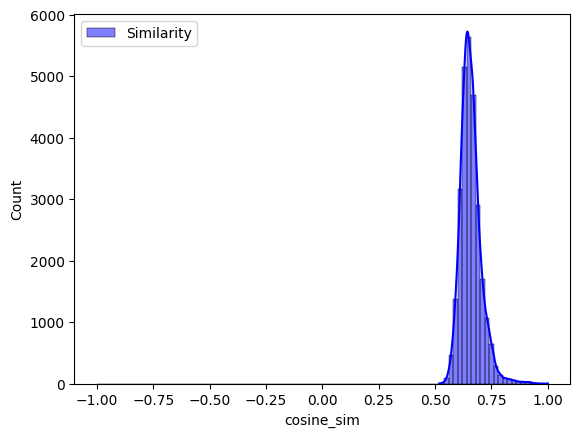

In [30]:
sns.histplot(tasks['cosine_sim'], binwidth=0.02, binrange=(-1, 1), color='blue', kde=True, label='Similarity')
plt.legend()
plt.show()